<a href="https://colab.research.google.com/github/SighOfFrostmourne/ECOM6022/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

## Environment setup and loading data

### Environment setup

In [2]:
# Python ≥3.5 and Scikit-Learn ≥0.20 are required
import sys
import sklearn
import numpy as np
import os

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures (for report etc)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
ROOT_PATH = "/content/drive/MyDrive/ECOM6022/Assignment_4"
os.chdir(ROOT_PATH)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Assignment_4"
DATA_PATH = os.path.join(ROOT_PATH, "datasets")
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Load data which already downloaded to Google Drive

In [3]:
import pandas as pd

def load_data(data_path=DATA_PATH):
    train_csv_path = os.path.join(data_path, "stock_market_training.csv")
    test_csv_path = os.path.join(data_path, "stock_market_testing.csv")
    return pd.read_csv(train_csv_path), pd.read_csv(test_csv_path)

train_data, test_data = load_data() 

## Take a quick look at the data

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      9000 non-null   float64
 1   F2      9000 non-null   float64
 2   F3      9000 non-null   float64
 3   F4      9000 non-null   float64
 4   F5      9000 non-null   float64
 5   F6      9000 non-null   float64
 6   F7      9000 non-null   float64
 7   F8      9000 non-null   float64
 8   F9      9000 non-null   float64
 9   F10     9000 non-null   float64
 10  Class   9000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 773.6 KB


In [8]:
train_data.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,Class
0,0.306251,1.227179,-0.590406,-0.843588,1.158658,-2.609219,-2.361603,-1.207631,-0.677193,1.009508,2
1,1.515725,-0.204145,-2.258348,0.945892,-2.120108,-0.304811,1.455660,0.785203,-1.157508,2.526830,1
2,-1.389026,0.115670,0.245705,0.225163,0.840018,-0.671928,-1.570313,-1.382368,0.068508,0.944927,0
3,-0.740551,-0.259994,-1.146410,-1.039870,-2.867487,-1.386472,0.101187,0.897933,-0.735515,2.477461,1
4,-0.927937,0.938241,-0.054460,1.453347,1.140367,0.906949,-1.237445,1.130820,1.584983,0.848553,0


In [10]:
train_data.describe()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,Class
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,-0.001831,0.002335,-0.333083,-0.329106,-0.016856,-0.004721,0.005932,-0.004874,0.008286,-0.007801,0.997667
std,1.006028,1.000002,1.732397,1.561179,1.719284,1.558986,1.000442,0.995425,0.993745,1.487237,0.815381
min,-3.722487,-3.642163,-7.411571,-5.909465,-7.112500,-4.682266,-3.492335,-3.880869,-3.851288,-5.306898,0.000000
25%,-0.675746,-0.675234,-1.496181,-1.415918,-1.199785,-1.121013,-0.661181,-0.679693,-0.669489,-1.079929,0.000000
50%,0.015263,0.009475,-0.458095,-0.441470,0.041727,-0.093299,0.003924,0.009280,0.012985,-0.022499,1.000000
75%,0.677262,0.682157,0.790806,0.738776,1.191769,1.086449,0.681353,0.663657,0.683734,1.068787,2.000000
max,3.856141,3.796725,6.492938,6.650862,6.125745,6.133881,4.093397,3.531378,4.079641,5.196704,2.000000


### Breif Analysis: 
There are 10 factors affecting the recommandation results (2 - Buy, 1 - Hold and 0 - Sell). All of them has very small mean and standard deviation. By further observation, F3 - F5 have relatively larger means. Therefore, they could be made as extra input_A in "Concat" layer, and all 10 factors to be used as input_B

## Data Preparation

### Split data
Separate the data and the lable. Further split it into validation sets

In [4]:
X_train_full = train_data.drop("Class", axis = 1)
y_train_full = train_data["Class"].copy()
X_test = test_data.drop("Class", axis = 1)
X_test_A = test_data. iloc[:, [2,3,4]]
y_test = test_data["Class"].copy()

# Split full training set to train and validation set
from sklearn.model_selection import train_test_split
X_train, X_train_valid, y_train, y_train_valid = train_test_split(X_train_full, y_train_full,
                                                    stratify=y_train_full, 
                                                    test_size=0.1, random_state=42)

# Use F3-F5 as an extra input
X_train_A = X_train. iloc[:, [2,3,4]]
X_train_A_valid = X_train_valid. iloc[:, [2,3,4]]

### Transform
Transform the datatype to numpy array frist, then use standardize scaler to transform training data

In [5]:
#No need for a pipeline here
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_train_valid_std = scaler.fit_transform(X_train_valid)
X_train_A_std = scaler.fit_transform(X_train_A)
X_train_A_valid_std = scaler.fit_transform(X_train_A_valid)
X_test_std = scaler.fit_transform(X_test)
X_test_A_std = scaler.fit_transform(X_test_A)

## Build the model

### Start with a simple one - sequential

In [85]:
import tensorflow as tf
from tensorflow import keras

sModel = keras.models.Sequential()
sModel.add(keras.layers.Flatten(input_shape=[10]))
sModel.add(keras.layers.Dense(10, activation="relu"))
sModel.add(keras.layers.Dense(5, activation="relu"))
sModel.add(keras.layers.Dense(3, activation="softmax")) # Use softmax as output layer for classification

# Initialize the environment variables before complie
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Compile the model
sModel.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

history_s = sModel.fit(X_train_std, y_train, epochs=40,
                    validation_data=(X_train_valid_std, y_train_valid))

Epoch 1/40
254/254 [==============================] - 1s 2ms/step - loss: 0.9401 - sparse_categorical_accuracy: 0.6136 - val_loss: 0.8087 - val_sparse_categorical_accuracy: 0.7044
Epoch 2/40
254/254 [==============================] - 0s 2ms/step - loss: 0.7063 - sparse_categorical_accuracy: 0.7348 - val_loss: 0.6501 - val_sparse_categorical_accuracy: 0.7400
Epoch 3/40
254/254 [==============================] - 0s 2ms/step - loss: 0.5965 - sparse_categorical_accuracy: 0.7700 - val_loss: 0.5890 - val_sparse_categorical_accuracy: 0.7622
Epoch 4/40
254/254 [==============================] - 0s 2ms/step - loss: 0.5486 - sparse_categorical_accuracy: 0.7894 - val_loss: 0.5518 - val_sparse_categorical_accuracy: 0.7933
Epoch 5/40
254/254 [==============================] - 0s 2ms/step - loss: 0.5172 - sparse_categorical_accuracy: 0.8027 - val_loss: 0.5266 - val_sparse_categorical_accuracy: 0.7956
Epoch 6/40
254/254 [==============================] - 0s 2ms/step - loss: 0.4952 - sparse_categorica

Saving figure keras_learning_curves_plot


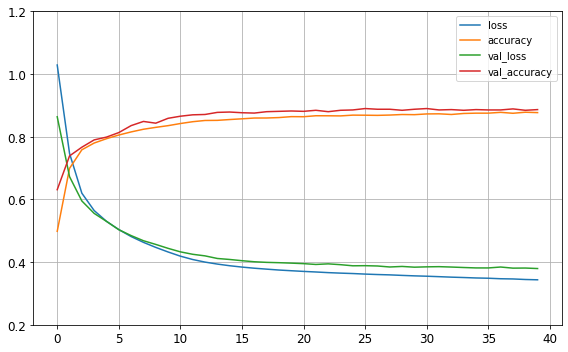

In [74]:
import pandas as pd

pd.DataFrame(history_s.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.2, 1.2)
save_fig("keras_learning_curves_plot")
plt.show()

### Observations: 
Validation loss is less than trainning loss at the beginning and later larger than trainning loss, which makes sense.
Validation accuracy is always lager than trainning accuracy which probably is just being lucky.


After 40 epoch we got the result: loss 0.3795 with accuracy 0.8867

### Functional API
It is expected to have a better performance as a recommander system

In [70]:
input_ = keras.layers.Input(shape=[10], name="wide_input")
input_A = keras.layers.Input(shape=[3], name="deep_input")
hidden1 = keras.layers.Dense(10, activation="relu")(input_)
hidden2 = keras.layers.Dense(5, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(3, activation="softmax", name="output")(concat)
model = keras.models.Model(inputs=[input_, input_A], outputs=[output])


# Initialize the environment variables before complie
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
              # Loss function to minimize
              loss=keras.losses.SparseCategoricalCrossentropy(),
              # List of metrics to monitor
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

#Training with Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("Functional_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history_f = model.fit((X_train_std, X_train_A_std), y_train, 
                    batch_size=32, #divid them to mini batches
                    epochs=100,
                    validation_data=((X_train_valid_std, X_train_A_valid_std), y_train_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
254/254 [==============================] - 2s 4ms/step - loss: 1.0901 - sparse_categorical_accuracy: 0.5294 - val_loss: 0.8452 - val_sparse_categorical_accuracy: 0.6089
Epoch 2/100
254/254 [==============================] - 1s 2ms/step - loss: 0.7080 - sparse_categorical_accuracy: 0.6965 - val_loss: 0.6328 - val_sparse_categorical_accuracy: 0.7489
Epoch 3/100
254/254 [==============================] - 1s 4ms/step - loss: 0.5731 - sparse_categorical_accuracy: 0.7784 - val_loss: 0.5478 - val_sparse_categorical_accuracy: 0.8022
Epoch 4/100
254/254 [==============================] - 1s 5ms/step - loss: 0.5135 - sparse_categorical_accuracy: 0.8021 - val_loss: 0.5031 - val_sparse_categorical_accuracy: 0.8133
Epoch 5/100
254/254 [==============================] - 2s 6ms/step - loss: 0.4755 - sparse_categorical_accuracy: 0.8149 - val_loss: 0.4720 - val_sparse_categorical_accuracy: 0.8267
Epoch 6/100
254/254 [==============================] - 2s 7ms/step - loss: 0.4478 - sparse_cate

Saving figure keras_learning_curves_plot_f


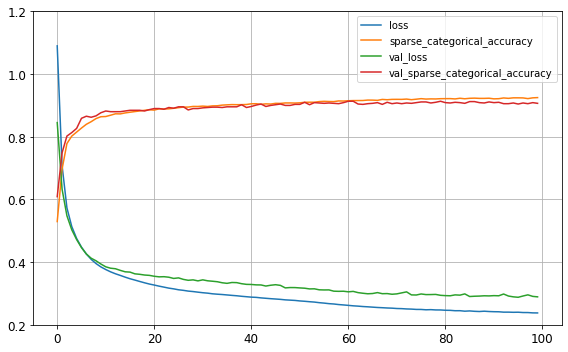

In [73]:
pd.DataFrame(history_f.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.2, 1.2)
save_fig("keras_learning_curves_plot_f")
plt.show()

### Hyperparameter Tuning

In [87]:
import tensorflow as tf
from tensorflow import keras

def build_model(n_hidden=1, n_neurons=10, learning_rate=3e-3, input_shape=[10]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(3, activation="softmax")) #Output 3 classes (2-Buy, 1- Hold, 0 - Sell)
    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  from ipykernel import kernelapp as app


In [91]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 10),#               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2), #.rvs(1000).tolist(),
}

#Initialize before search
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train_std, y_train, epochs=100,
                  validation_data=(X_train_valid_std, y_train_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
169/169 [==============================] - 1s 2ms/step - loss: 1.3691 - sparse_categorical_accuracy: 0.3609 - val_loss: 1.1093 - val_sparse_categorical_accuracy: 0.4522
Epoch 2/100
169/169 [==============================] - 0s 2ms/step - loss: 0.9580 - sparse_categorical_accuracy: 0.5513 - val_loss: 0.8290 - val_sparse_categorical_accuracy: 0.6322
Epoch 3/100
169/169 [==============================] - 1s 4ms/step - loss: 0.7571 - sparse_categorical_accuracy: 0.6928 - val_loss: 0.7109 - val_sparse_categorical_accuracy: 0.7144
Epoch 4/100
169/169 [==============================] - 1s 3ms/step - loss: 0.6764 - sparse_categorical_accuracy: 0.7391 - val_loss: 0.6681 - val_sparse_categorical_accuracy: 0.7289
Epoch 5/100
169/169 [==============================] - 1s 3ms/step - loss: 0.6465 - sparse_categorical_accuracy: 0.7537 - val_loss: 0.6518 - val_sparse_categorical_accuracy: 0.7322
Epoch 6/100
169/169 [=============

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f807c613c90>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f807ce00b10>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
                   verbose=2)

In [92]:
rnd_search_cv.best_params_

{'learning_rate': 0.0013948852342008993, 'n_hidden': 3, 'n_neurons': 8}

In [66]:
rnd_search_cv.best_score_

-0.25988782445589703

In [93]:
model_s_best = rnd_search_cv.best_estimator_.model
model_s_best.save("Sequential_model.h5")

## Model Evaluation
Evaluate the models on test data set

In [86]:
# The initial model
sModel.evaluate(X_test_std, y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.3563 - sparse_categorical_accuracy: 0.8790


[0.3562699556350708, 0.8790000081062317]

In [94]:
best_sequential_model = keras.models.load_model("Sequential_model.h5")
best_sequential_model.evaluate(X_test_std, y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.2942 - sparse_categorical_accuracy: 0.9010


[0.2942047417163849, 0.9010000228881836]

In [83]:
funtional_model = keras.models.load_model("Functional_model.h5")
funtional_model.evaluate((X_test_std, X_test_A_std), y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.3042 - sparse_categorical_accuracy: 0.9080


[0.30423223972320557, 0.9079999923706055]

## Conclusion and summary

Surprisingly, without any hyperparameter tunning, the funtional model has almost the same performance as the best tunned sequential model. If only looks at the accuracy, the "random" built funtion model is the best model we should use here.

It is hard to tell if 90% accuracy is enough for predicting the position of a stock. The more tricky thing is that the label potions may not be correct. Assuming in extremely condition the perfect model predicts 100% correct with the labels(buy,sell,hold), but the label itself is a prediction made by financial analysts/institutions. It would be more worthy to build the model on price change directly than the position.